In [54]:
import pandas as pd
import scipy.optimize as opt;
import re
from io import BytesIO
import numpy as np
import cairo
import IPython.display

epoch = 1
epochs = [i for i in range(1,10)]

folder = "Locarno/"
#folder = "Random/"

Df = pd.read_csv("../../membershipchainservice/Data/"+folder+"gentree-node_0-epoch"+str(epoch))
Df

,Name,Level,X,Y,cluster,bunch
0,node_0,1,40.309273,254.230121,map[],map[node_2:true]
1,node_1,0,246.532589,87.920694,map[],map[node_2:true]
2,node_2,2,148.630526,134.847319,map[node_0:true node_1:true node_3:true],map[]
3,node_3,0,195.477892,236.617005,map[],map[node_2:true]


In [2]:
def transform_Df(Df):
    regex = r"(node_[0-9]+)"
    explode_list_lambda = lambda map_str : [m.group() for m in re.finditer(regex, map_str, re.MULTILINE)]
    Df["cluster_list"] = Df["cluster"].apply(explode_list_lambda)
    Df["bunch_list"] = Df["bunch"].apply(explode_list_lambda)

transform_Df(Df)
Df

,Name,Level,X,Y,cluster,bunch,cluster_list,bunch_list
0,node_0,2,40.309273,254.230121,map[node_1:true node_2:true node_3:true],map[],"[node_1, node_2, node_3]",[]
1,node_1,0,246.532589,87.920694,map[node_2:true],map[node_0:true node_2:true node_3:true],[node_2],"[node_0, node_2, node_3]"
2,node_2,0,148.630526,134.847319,map[node_1:true],map[node_0:true node_1:true node_3:true],[node_1],"[node_0, node_1, node_3]"
3,node_3,1,195.477892,236.617005,map[node_1:true node_2:true],map[node_0:true],"[node_1, node_2]",[node_0]


In [3]:
def cover_cluster(radius, name, Df):
    node = Df[Df["Name"]==name]
    cl = list(Df[Df["Name"]==name].cluster_list)[0]
    if len(cl) == 0:
        return True
    
    distance_lambda = lambda row : np.sqrt((row.X-node.X)**2 + (row.Y-node.Y)**2)
    distances = Df[Df["Name"].isin(cl)].apply(distance_lambda, axis=1)
    if radius < distances.max().values[0]:
        return False
    
    return True
    
def compute_radius(name, Df, base):
    radius = base
    while not cover_cluster(radius, name, Df):
        radius *= 2
    return radius

In [4]:
palette = [
    [64/255, 64/255, 122/255,1.0],
    [255/255, 121/255, 63/255,1.0],
    [255/255, 177/255, 66/255,1.0],
    [52/255, 172/255, 224/255,1.0],
    
]

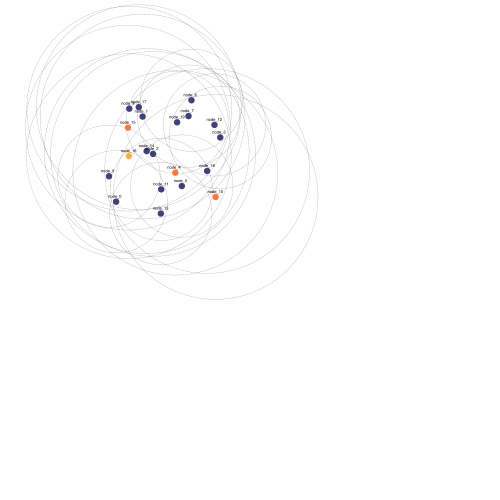

In [26]:
svgio = BytesIO()
side = 500

def draw_df_on(Df,svgio, epoch, folder):
    with cairo.SVGSurface(svgio, side, side) as surface:
        context = cairo.Context(surface)
        context.scale(0.4,0.4)
        context.translate(side/2, side/2)

        context.set_source_rgba(0,0,0,1)
        context.set_dash([1.0])
        context.set_line_width(0.5)
        for row in Df.iterrows():
            Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
            context.arc(X, Y, compute_radius(Name, Df, 16), 0, 2*np.pi)
            context.stroke()

        for row in Df.iterrows():
            Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
            context.set_source_rgba(*palette[Level])
            context.arc(X, Y, 8, 0, 2*np.pi)
            context.fill()

        context.set_source_rgba(0,0,0,1)
        for row in Df.iterrows():
            Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
            context.move_to(X-20,Y-10)
            context.show_text(Name)
            context.stroke()
    with open(folder+"/epoch"+str(epoch)+"_map.svg",'wb') as f:
        f.write(svgio.getvalue())


draw_df_on(Df,svgio, epoch, folder)
IPython.display.SVG(data=svgio.getvalue())
#svgio.close()

In [6]:
def compute_difference(old_Df, Df): 
    difference = 0    
    for row in Df.iterrows():
        Name, Level, X, Y, cluster, bunch, cluster_list, bunch_list = row[1]
        if len(old_Df) != 0 and len(old_Df[old_Df["Name"]==Name]) != 0:
            old_cluster_list = list(old_Df[old_Df["Name"]==Name].cluster_list)[0]
            old_bunch_list = list(old_Df[old_Df["Name"]==Name].bunch_list)[0]
            difference += len(cluster_list) - len(set(cluster_list) & set(old_cluster_list))
            difference += len(bunch_list) - len(set(bunch_list) & set(old_bunch_list))
            #print(old_cluster_list,cluster_list,set(cluster_list) & set(old_cluster_list))
        else:
            difference += len(cluster_list) + len(bunch_list)        
    return difference

In [60]:
folders = ["Random", "Locarno"]
difference_per_folder = []
svgs_per_folder = []
for folder in folders:
    SVGs = []
    Df = []
    old_Df = []
    differences = []
    print(folder, " : ")
    for epoch in epochs:  
        old_Df = Df
        Df = pd.read_csv("../../membershipchainservice/Data/"+folder+"/gentree-node_0-epoch"+str(epoch))
        transform_Df(Df)
        svgio = BytesIO()
        SVGs.append(svgio)
        draw_df_on(Df, svgio, epoch, folder)
        diff = compute_difference(old_Df, Df)
        differences.append(diff)
        print(diff)
    print("\n")
    difference_per_folder.append(differences)
    svgs_per_folder.append(SVGs)

Random  : 
14
20
14
50
56
78
80
108
166


Locarno  : 
6
16
16
26
52
36
70
70
58




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


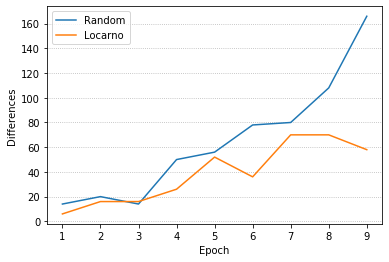

In [31]:
import matplotlib.pyplot as plt

plt.plot(epochs, difference_per_folder[0])
plt.plot(epochs, difference_per_folder[1])
plt.legend(folders)
plt.grid(axis="y", linestyle='dotted')
plt.ylabel("Differences")
plt.xlabel("Epoch")

plt.savefig("differences.eps")
plt.show()

In [61]:
from svgutils.compose import *
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF

for folder in folders:
    nb_per_line = 3

    paths = [folder+"/epoch"+str(epoch)+"_map.svg" for epoch in epochs]
    panels = [Panel(SVG(p), Text(str(i), 25, 20, size=12, weight='bold')).move(side*(i%nb_per_line), side*int(i/nb_per_line)) for i, p in enumerate(paths)]

    Figure(side*nb_per_line, side*(int(len(panels)/nb_per_line)), *panels).save(folder+"/fig_final_compose.svg")
    drawing = svg2rlg(folder+"/fig_final_compose.svg")
    renderPDF.drawToFile(drawing, folder+"/final.pdf")
